In [4]:
import pandas as pd
import numpy as np
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats.stats import pearsonr

In [5]:
df = pd.read_csv('C://Users/norouziy/Desktop/SARA/501/Project/project-saragholami/sample/travis_torrent_refined.csv')

C:\Users\norouziy\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
df = df.sort_values('gh_team_size')

In [40]:
df.shape

(3115284, 52)

In [7]:
team_size = df.gh_team_size.unique()
print(team_size)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]


In [83]:
sample_set = 100

In [84]:
src_sloc = np.zeros((sample_set, len(team_size)))
test_sloc = np.zeros((sample_set, len(team_size)))
status_failed = np.zeros((sample_set, len(team_size)))
status_passed = np.zeros((sample_set, len(team_size)))
test_failed = np.zeros((sample_set, len(team_size)))
test_ok = np.zeros((sample_set, len(team_size)))
date = np.zeros((sample_set, len(team_size)))
src_date_res = np.zeros((sample_set, len(team_size)))
test_date_res = np.zeros((sample_set, len(team_size)))

In [85]:
for i in range(sample_set):
    print(i)
    sample = df.sample(frac=0.7, replace=True)
    print(sample.shape)
    sample = sample.sort_values('gh_team_size')
    
    for index, threshold in enumerate(team_size):
        if index == 0 or index == len(team_size) - 1:
            continue

        src = sample.groupby('gh_team_size', as_index=False)['git_diff_src_churn'].mean()
        test = sample.groupby('gh_team_size', as_index=False)['git_diff_test_churn'].mean()
        sloc = sample.groupby('gh_team_size', as_index=False)['gh_sloc'].mean()
        counts = sample.groupby(['gh_team_size']).size().reset_index(name='counts')
        failed = sample.groupby(['gh_team_size']).tr_status.value_counts().unstack(fill_value=0).loc[:, 0].tolist()
        passed = sample.groupby(['gh_team_size']).tr_status.value_counts().unstack(fill_value=0).loc[:, 1].tolist()
        failed_tests = df.groupby('gh_team_size', as_index=False)['tr_log_num_tests_failed'].mean()
        ok_tests = sample.groupby('gh_team_size', as_index=False)['tr_log_num_tests_ok'].mean()
        total_tests = sample.groupby('gh_team_size', as_index=False)['tr_log_num_tests_run'].mean()
        date_diff = sample.groupby('gh_team_size', as_index=False)['date_diff'].mean()
        src_date = sample.groupby('gh_team_size', as_index=False)['src_date'].mean()
        test_date = sample.groupby('gh_team_size', as_index=False)['test_date'].mean()
        
        sloc_list = sloc['gh_sloc'].tolist()
        test_list = test['git_diff_test_churn'].tolist()
        src_list = src['git_diff_src_churn'].tolist()
        failed_tests_list = failed_tests['tr_log_num_tests_failed'].tolist()
        total_tests_list = total_tests['tr_log_num_tests_run'].tolist()
        ok_tests_list = ok_tests['tr_log_num_tests_ok'].tolist()
        date_diff_list = date_diff['date_diff'].tolist()
        src_date_list = src_date['src_date'].tolist()
        test_date_list = test_date['test_date'].tolist()
        total_status = list(counts['counts'])

        lower_half_mean_src = np.mean(src_list[:index]) / np.mean(sloc_list[:index])
        upper_half_mean_src = np.mean(src_list[index:]) / np.mean(sloc_list[index:])
        
        lower_half_mean_test = np.mean(test_list[:index]) / np.mean(sloc_list[:index])
        upper_half_mean_test = np.mean(test_list[index:]) / np.mean(sloc_list[index:])
        
        lower_half_mean_failure = np.mean(failed[:index]) / np.mean(total_status[:index])
        upper_half_mean_failure = np.mean(failed[index:]) / np.mean(total_status[index:])

        lower_half_mean_passed = np.mean(passed[:index]) / np.mean(total_status[:index])
        upper_half_mean_passed = np.mean(passed[index:]) / np.mean(total_status[index:])
        
        lower_half_failed_tests = np.mean(failed_tests_list[:index]) / np.mean(total_tests_list[:index])
        upper_half_failed_tests = np.mean(failed_tests_list[index:]) / np.mean(total_tests_list[index:])
        
        lower_half_ok_tests = np.mean(ok_tests_list[:index]) / np.mean(total_tests_list[:index])
        upper_half_ok_tests = np.mean(ok_tests_list[index:]) / np.mean(total_tests_list[index:])
        
        lower_half_date_diff = np.mean(date_diff_list[:index])
        upper_half_date_diff = np.mean(date_diff_list[index:])
        
        lower_half_src_date = np.mean(src_date_list[:index])
        upper_half_src_date = np.mean(src_date_list[index:])
        
        lower_half_test_date = np.mean(test_date_list[:index])
        upper_half_test_date = np.mean(test_date_list[index:])

        src_sloc[i][index] = lower_half_mean_src - upper_half_mean_src
        test_sloc[i][index] = lower_half_mean_test - upper_half_mean_test
        status_failed[i][index] = lower_half_mean_failure - upper_half_mean_failure
        status_passed[i][index] = lower_half_mean_passed - upper_half_mean_passed
        test_failed[i][index] = lower_half_failed_tests - upper_half_failed_tests
        test_ok[i][index] = lower_half_ok_tests - upper_half_ok_tests
        date[i][index] = lower_half_date_diff - upper_half_date_diff
        src_date_res[i][index] = lower_half_src_date - upper_half_src_date
        test_date_res[i][index] = lower_half_test_date - upper_half_test_date

0
(2180699, 52)
1
(2180699, 52)
2
(2180699, 52)
3
(2180699, 52)
4
(2180699, 52)
5
(2180699, 52)
6
(2180699, 52)
7
(2180699, 52)
8
(2180699, 52)
9
(2180699, 52)
10
(2180699, 52)
11
(2180699, 52)
12
(2180699, 52)
13
(2180699, 52)
14
(2180699, 52)
15
(2180699, 52)
16
(2180699, 52)
17
(2180699, 52)
18
(2180699, 52)
19
(2180699, 52)
20
(2180699, 52)
21
(2180699, 52)
22
(2180699, 52)
23
(2180699, 52)
24
(2180699, 52)
25
(2180699, 52)
26
(2180699, 52)
27
(2180699, 52)
28
(2180699, 52)
29
(2180699, 52)
30
(2180699, 52)
31
(2180699, 52)
32
(2180699, 52)
33
(2180699, 52)
34
(2180699, 52)
35
(2180699, 52)
36
(2180699, 52)
37
(2180699, 52)
38
(2180699, 52)
39
(2180699, 52)
40
(2180699, 52)
41
(2180699, 52)
42
(2180699, 52)
43
(2180699, 52)
44
(2180699, 52)
45
(2180699, 52)
46
(2180699, 52)
47
(2180699, 52)
48
(2180699, 52)
49
(2180699, 52)
50
(2180699, 52)
51
(2180699, 52)
52
(2180699, 52)
53
(2180699, 52)
54
(2180699, 52)
55
(2180699, 52)
56
(2180699, 52)
57
(2180699, 52)
58
(2180699, 52)
59
(218

In [98]:
compare_src_sloc = src_sloc > 0
compare_test_sloc = test_sloc > 0
compare_status_failed = status_failed > 0
compare_status_passed = status_passed > 0
compare_test_failed = test_failed > 0
compare_test_ok = test_ok > 0
compare_date_dif = date > 0
compare_src_date = src_date_res > 0
compare_test_date = test_date_res > 0

In [47]:
np.sum(compare_test_ok[:, 10])

10

In [92]:
print(src_sloc)
print(src_sloc.shape)

[[0.         0.00574236 0.01030227 ... 0.00079289 0.00121154 0.        ]
 [0.         0.00723852 0.00999676 ... 0.00076886 0.00100719 0.        ]
 [0.         0.00580269 0.01170383 ... 0.0007323  0.00117618 0.        ]
 ...
 [0.         0.00930652 0.01323125 ... 0.00095486 0.00129685 0.        ]
 [0.         0.00667217 0.01150513 ... 0.00081225 0.00133348 0.        ]
 [0.         0.00636744 0.00834345 ... 0.00097788 0.00131411 0.        ]]
(100, 60)


In [61]:
print(compare_test_ok.shape)

(10, 60)


In [99]:
sum_src_sloc = np.zeros(len(team_size))
sum_test_sloc = np.zeros(len(team_size))
sum_status_failed = np.zeros(len(team_size))
sum_status_passed = np.zeros(len(team_size))
sum_test_failed = np.zeros(len(team_size))
sum_test_ok = np.zeros(len(team_size))
sum_date_diff = np.zeros(len(team_size))
sum_src_date = np.zeros(len(team_size))
sum_test_date = np.zeros(len(team_size))
for i in range(len(team_size)):
    sum_src_sloc[i] = np.sum(compare_src_sloc[:, i])
    sum_test_sloc[i] = np.sum(compare_test_sloc[:, i])
    sum_status_failed[i] = np.sum(compare_status_failed[:, i])
    sum_status_passed[i] = np.sum(compare_status_passed[:, i])
    sum_test_failed[i] = np.sum(compare_test_failed[:, i])
    sum_test_ok[i] = np.sum(compare_test_ok[:, i])
    sum_date_diff[i] = np.sum(compare_date_dif[:, i])
    sum_src_date[i] = np.sum(compare_src_date[:, i])
    sum_test_date[i] = np.sum(compare_test_date[:, i])

In [63]:
print(sum_src_sloc)

[ 0. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10.  0.]


In [64]:
print(sum_test_sloc)

[ 0. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.  8.  6.  4.  5.
  3.  5.  0.  0.  5.  0.]


In [65]:
print(sum_status_failed)

[ 0. 10. 10.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  5.  7.  0.  0.]


In [66]:
print(sum_status_passed)

[ 0.  0.  0. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10.  5.  3. 10.  0.]


In [67]:
print(sum_test_failed)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  6.  9. 10.  9.  8.
  9.  9. 10. 10.  6.  6.  6. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10.  0.]


In [68]:
print(sum_test_ok)

[ 0. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10.  8.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.]


In [100]:
mean_threshold = np.zeros(len(team_size))
for i in range(len(team_size)):
    mean_threshold[i] = np.mean(np.array([sum_src_sloc[i], sum_test_sloc[i], sum_status_failed[i], sum_status_passed[i], sum_test_failed[i], sum_test_ok[i], sum_date_diff[i], sum_src_date[i], sum_test_date[i]]))

In [101]:
print(mean_threshold)

[ 0.         44.55555556 72.         70.11111111 77.77777778 77.77777778
 77.77777778 77.77777778 77.77777778 77.77777778 77.77777778 77.77777778
 77.77777778 87.         88.77777778 88.77777778 88.77777778 88.44444444
 88.77777778 88.77777778 88.77777778 88.77777778 87.33333333 87.11111111
 87.33333333 88.77777778 88.77777778 88.77777778 88.88888889 88.77777778
 88.88888889 88.88888889 88.88888889 88.88888889 88.88888889 88.88888889
 88.88888889 88.88888889 88.33333333 86.88888889 84.33333333 81.11111111
 73.44444444 66.66666667 66.66666667 66.66666667 66.66666667 66.66666667
 66.55555556 65.55555556 62.44444444 60.         58.44444444 57.77777778
 57.         58.44444444 55.77777778 55.77777778 68.33333333  0.        ]


In [102]:
np.argmax(mean_threshold)

28

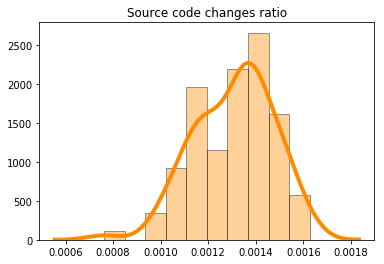

In [124]:
sns.distplot(src_sloc[:, 28], hist=True, kde=True,
                 bins=10, color='darkorange',
                 hist_kws={'edgecolor': 'black'},
                 kde_kws={'linewidth': 4}).set_title('Source code changes ratio')
plt.savefig('./figs2/src_sloc_ratio.png', dpi=1000)

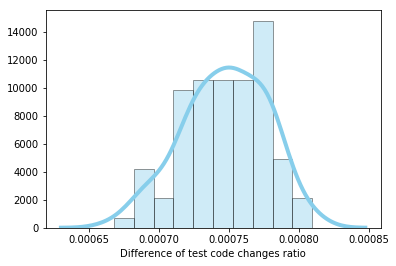

In [208]:
x = pd.Series(test_sloc[:, 28], name="Difference of test code changes ratio")
sns.distplot(x, hist=True, kde=True,
                 bins=10, color='skyblue',
                 hist_kws={'edgecolor': 'black'},
                 kde_kws={'linewidth': 4})
plt.savefig('./figs2/test_sloc_ratio.png', dpi=1000)

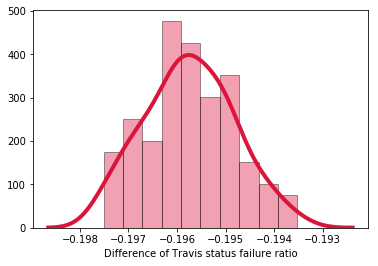

In [209]:
x = pd.Series(status_failed[:, 28], name="Difference of Travis status failure ratio")
sns.distplot(x, hist=True, kde=True,
                 bins=10, color='crimson',
                 hist_kws={'edgecolor': 'black'},
                 kde_kws={'linewidth': 4})
plt.savefig('./figs2/status_failed.png', dpi=1000)

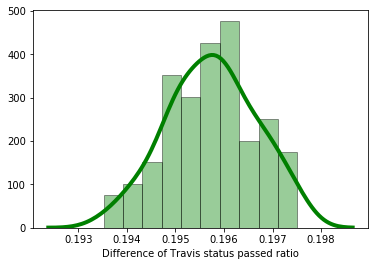

In [210]:
x = pd.Series(status_passed[:, 28], name="Difference of Travis status passed ratio")
sns.distplot(x, hist=True, kde=True,
                 bins=10, color='green',
                 hist_kws={'edgecolor': 'black'},
                 kde_kws={'linewidth': 4})
plt.savefig('./figs2/status_passed.png', dpi=1000)

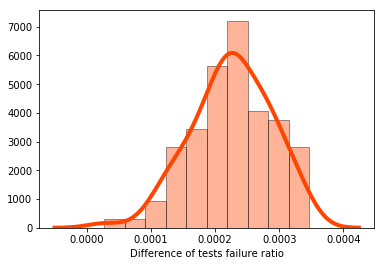

In [211]:
x = pd.Series(test_failed[:, 28], name="Difference of tests failure ratio")
sns.distplot(x, hist=True, kde=True,
                 bins=10, color='orangered',
                 hist_kws={'edgecolor': 'black'},
                 kde_kws={'linewidth': 4})
plt.savefig('./figs2/test_failed_ratio.png', dpi=1000)

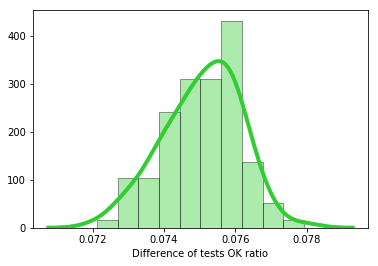

In [212]:
x = pd.Series(test_ok[:, 28], name="Difference of tests OK ratio")
sns.distplot(x, hist=True, kde=True,
                 bins=10, color='limegreen',
                 hist_kws={'edgecolor': 'black'},
                 kde_kws={'linewidth': 4})
plt.savefig('./figs2/test_ok_ratio.png', dpi=1000)

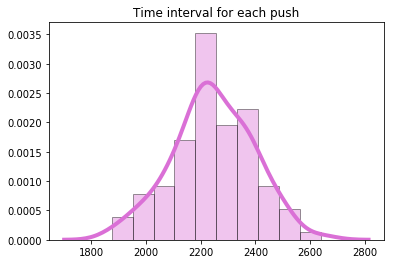

In [130]:
sns.distplot(date[:, 28], hist=True, kde=True,
                 bins=10, color='orchid',
                 hist_kws={'edgecolor': 'black'},
                 kde_kws={'linewidth': 4}).set_title('Time interval for each push')
plt.savefig('./figs2/date.png', dpi=1000)

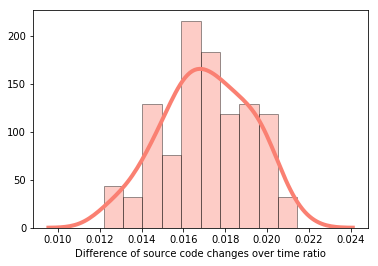

In [215]:
x = pd.Series(src_date_res[:, 28], name="Difference of source code changes over time ratio")
sns.distplot(x, hist=True, kde=True,
                 bins=10, color='salmon',
                 hist_kws={'edgecolor': 'black'},
                 kde_kws={'linewidth': 4})
plt.savefig('./figs2/src_date_ratio.png', dpi=1000)

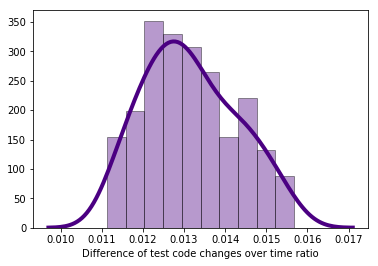

In [213]:
x = pd.Series(test_date_res[:, 28], name="Difference of test code changes over time ratio")
sns.distplot(x, hist=True, kde=True,
                 bins=10, color='indigo',
                 hist_kws={'edgecolor': 'black'},
                 kde_kws={'linewidth': 4})
plt.savefig('./figs2/test_date_ratio.png', dpi=1000)

In [170]:
pearsonr(df['gh_team_size'], df['date_diff'])

(nan, 1.0)

In [73]:
df.dtypes

Unnamed: 0                           int64
gh_project_name                     object
gh_pr_created_at                    object
gh_lang                             object
gh_num_commits_in_push             float64
gh_first_commit_created_at          object
gh_team_size                         int64
git_num_all_built_commits            int64
gh_num_issue_comments              float64
gh_num_commit_comments               int64
gh_num_pr_comments                 float64
git_diff_src_churn                   int64
git_diff_test_churn                  int64
gh_diff_files_added                  int64
gh_diff_files_deleted                int64
gh_diff_files_modified               int64
gh_diff_tests_added                  int64
gh_diff_tests_deleted                int64
gh_diff_src_files                    int64
gh_diff_doc_files                    int64
gh_diff_other_files                  int64
gh_num_commits_on_files_touched      int64
gh_sloc                              int64
gh_test_lin

In [134]:
stats.ks_2samp(df['gh_team_size'], df['date_diff'])

Ks_2sampResult(statistic=0.5449814527343254, pvalue=0.0)

In [135]:
stats.ks_2samp(df['gh_team_size'], df['src_date'])

Ks_2sampResult(statistic=0.7823774654253031, pvalue=0.0)

In [136]:
stats.ks_2samp(df['gh_team_size'], df['test_date'])

Ks_2sampResult(statistic=0.7854523054719891, pvalue=0.0)

In [137]:
stats.ks_2samp(df['gh_team_size'], df['test_diff_ratio'])

Ks_2sampResult(statistic=0.9963149427146931, pvalue=0.0)

In [138]:
stats.ks_2samp(df['gh_team_size'], df['src_diff_ratio'])

Ks_2sampResult(statistic=0.9945626145160441, pvalue=0.0)

In [139]:
stats.ttest_ind(df['gh_team_size'], df['tr_status'])

Ttest_indResult(statistic=1918.6247274678876, pvalue=0.0)

In [140]:
stats.ks_2samp(df['gh_team_size'], df['tr_log_num_tests_failed'])

Ks_2sampResult(statistic=0.5118695438361318, pvalue=0.0)

In [142]:
stats.ks_2samp(df['gh_team_size'], df['tr_log_num_tests_ok'])

Ks_2sampResult(statistic=0.8697261630079312, pvalue=0.0)

In [141]:
stats.ks_2samp(df['gh_team_size'], df['tr_log_num_tests_run'])

Ks_2sampResult(statistic=0.906424903796893, pvalue=0.0)

In [8]:
sample = df.sample(frac=0.7)

In [9]:
src = sample.groupby('gh_team_size', as_index=False)['git_diff_src_churn'].mean()
test = sample.groupby('gh_team_size', as_index=False)['git_diff_test_churn'].mean()
t_sloc = sample.groupby('gh_team_size', as_index=False)['gh_test_lines_per_kloc'].mean()
sloc = sample.groupby('gh_team_size', as_index=False)['gh_sloc'].mean()
sloc_list = np.array(sloc['gh_sloc'].tolist(), dtype=np.float)
t_sloc_list = np.array(t_sloc['gh_test_lines_per_kloc'].tolist(), dtype=np.float)
test_list = np.array(test['git_diff_test_churn'].tolist(), dtype=np.float)
src_list = np.array(src['git_diff_src_churn'].tolist(), dtype=np.float)

In [10]:
# this means there is a correlation between team size and changes of source code ratio
# pearsonr(team_size, ss)
stats.spearmanr(team_size, src_list / sloc_list)

SpearmanrResult(correlation=-0.7226451792164492, pvalue=7.091676106167226e-11)

In [11]:
stats.mannwhitneyu(team_size, src_list / sloc_list)

MannwhitneyuResult(statistic=60.0, pvalue=3.424736600788257e-20)

In [12]:
# this means there is a correlation between team size and changes of test code ratio
# pearsonr(team_size, ts)
stats.spearmanr(team_size, test_list / t_sloc_list * sloc_list)

SpearmanrResult(correlation=0.6447346485134761, pvalue=2.704766543330544e-08)

In [13]:
stats.mannwhitneyu(team_size, test_list / t_sloc_list * sloc_list)

MannwhitneyuResult(statistic=0.0, pvalue=1.7782854874923613e-21)

In [200]:
# Travis status
counts = sample.groupby(['gh_team_size']).size().reset_index(name='counts')
failed = np.array(sample.groupby(['gh_team_size']).tr_status.value_counts().unstack(fill_value=0).loc[:, 0].tolist(), dtype=np.float)
passed = np.array(sample.groupby(['gh_team_size']).tr_status.value_counts().unstack(fill_value=0).loc[:, 1].tolist(), dtype=np.float)

total_status = np.array(list(counts['counts']), dtype=np.float)
stats.spearmanr(team_size, passed / total_status)

SpearmanrResult(correlation=-0.43517643789941657, pvalue=0.0005111201972021636)

In [192]:
stats.spearmanr(team_size, failed / total_status)

SpearmanrResult(correlation=0.43517643789941657, pvalue=0.0005111201972021636)

In [14]:
# tests
failed_tests = sample.groupby('gh_team_size', as_index=False)['tr_log_num_tests_failed'].mean()
ok_tests = sample.groupby('gh_team_size', as_index=False)['tr_log_num_tests_ok'].mean()
total_tests = sample.groupby('gh_team_size', as_index=False)['tr_log_num_tests_run'].mean()

failed_tests_list = np.array(failed_tests['tr_log_num_tests_failed'].tolist(), dtype=np.float)
total_tests_list = np.array(total_tests['tr_log_num_tests_run'].tolist(), dtype=np.float)
ok_tests_list = np.array(ok_tests['tr_log_num_tests_ok'].tolist(), dtype=np.float)
stats.spearmanr(team_size, failed_tests_list / total_tests_list)

SpearmanrResult(correlation=-0.34654070575159773, pvalue=0.006679139501587907)

In [15]:
stats.spearmanr(team_size, ok_tests_list / total_tests_list)

SpearmanrResult(correlation=0.002445123645457072, pvalue=0.9852069139288007)

In [195]:
# date
date_diff = sample.groupby('gh_team_size', as_index=False)['date_diff'].mean()
src_date = sample.groupby('gh_team_size', as_index=False)['src_date'].mean()
test_date = sample.groupby('gh_team_size', as_index=False)['test_date'].mean()

date_diff_list = np.array(date_diff['date_diff'].tolist(), dtype=np.float)
src_date_list = np.array(src_date['src_date'].tolist(), dtype=np.float)
test_date_list = np.array(test_date['test_date'].tolist(), dtype=np.float)

stats.spearmanr(team_size, date_diff_list)

SpearmanrResult(correlation=-0.4230063906640734, pvalue=0.0007592467266302635)

In [196]:
stats.spearmanr(team_size, test_date_list)

SpearmanrResult(correlation=-0.8230063906640736, pvalue=7.131715052026028e-16)

In [197]:
stats.spearmanr(team_size, src_date_list)

SpearmanrResult(correlation=-0.7205334815226453, pvalue=8.551127482448382e-11)